In [1]:
import numpy as np
import pandas as pd

import geopy.distance

from sklearn.decomposition import PCA

import shutil
import os

import time
import json

from collections import OrderedDict

In [2]:
from utils.PreProcessor import PreProcessor
preprocessor = PreProcessor(sample_num = 1, preprocess_all_raw_data = False)

tier_1_2_cities_raw = [
    'Ahmedabad', 'Bengaluru', 'Mumbai', 'Pune', 'Chennai', 'Hyderabad', 'Kolkata', 'Delhi', 'Visakhapatnam', 'Guwahati', 'Patna',
    'Raipur', 'Gurugram', 'Shimla', 'Jamshedpur', 'Thiruvananthapuram', 'Bhopal', 'Bhubaneswar', 'Amritsar', 'Jaipur', 'Lucknow', 'Dehradun'
]
tier_1_2_cities_raw = tier_1_2_cities_raw + (
    "Guntur, Kakinada, Kurnool, Nellore, Rajamahendravaram, Vijayawada".split(', ')
) + (
    "Bilaspur, Bhilai".split(', ')
) + (
    "Anand, Bhavnagar, Dahod, Jamnagar, Rajkot, Surat, Vadodara".split(', ')
) + (
    "Faridabad, Karnal".split(', ')
) + (
    "Hamirpur".split(', ')
) + (
    "Bokaro Steel City, Dhanbad, Ranchi".split(', ')
) + (
    "Belagavi, Hubballi-Dharwad, Kalaburagi, Mangaluru, Mysuru, Vijayapura".split(', ')
) + (
    "Kannur, Kochi, Kollam, Kozhikode, Malappuram, Thrissur".split(', ')
) + (
    "Gwalior, Indore, Jabalpur, Ratlam, Ujjain".split(', ')
) + (
    "Amravati, Aurangabad, Bhiwandi, Dombivli, Jalgaon, Kolhapur, Nagpur, Nanded, Nashik, Sangli, Solapur, Vasai-Virar".split(', ')
) + (
    "Cuttack, Rourkela".split(', ')
) + (
    "Jalandhar, Ludhiana".split(', ')
) + (
    "Ajmer, Bikaner, Jodhpur".split(', ')
) + (
    "Coimbatore, Erode, Madurai, Salem, Thanjavur, Tiruchirappalli, Tirunelveli, Tiruvannamalai, Vellore".split(', ')
) + (
    "Warangal".split(', ')
) + (
    "Agra, Aligarh, Bareilly, Ghaziabad, Gorakhpur, Jhansi, Kanpur, Mathura, Meerut, Moradabad, Noida, Prayagraj, Varanasi".split(', ')
) + (
    "Asansol, Berhampore, Burdwan, Durgapur, Purulia, Siliguri".split(', ')
) + (
    "Chandigarh, Jammu, Puducherry, Srinagar".split(', ')
)

**************************************
Loading PreProcessed Datasets
Loaded AirRouteDatasets
Loaded Domestic Passenger Data
Loaded Indian Railways Data
Loaded Socio-Economic Data
Loaded Monument Visitors Data
**************************************


In [3]:
city_to_airport_map = dict(zip(preprocessor.city_mapping['City'].values, preprocessor.city_mapping['AirRouteData_AirportCode']))
tier_1_2_cities = [x for x in tier_1_2_cities_raw if pd.isnull(city_to_airport_map[x]) == False]
tier_1_2_cities_airports = preprocessor.city_mapping['AirRouteData_AirportCode'].dropna().values

In [4]:
len(tier_1_2_cities), tier_1_2_cities, tier_1_2_cities_airports

(62,
 ['Ahmedabad',
  'Bengaluru',
  'Mumbai',
  'Pune',
  'Chennai',
  'Hyderabad',
  'Kolkata',
  'Delhi',
  'Visakhapatnam',
  'Guwahati',
  'Patna',
  'Raipur',
  'Thiruvananthapuram',
  'Bhopal',
  'Bhubaneswar',
  'Amritsar',
  'Jaipur',
  'Lucknow',
  'Dehradun',
  'Kurnool',
  'Rajamahendravaram',
  'Vijayawada',
  'Bilaspur',
  'Bhavnagar',
  'Jamnagar',
  'Rajkot',
  'Surat',
  'Vadodara',
  'Ranchi',
  'Belagavi',
  'Hubballi-Dharwad',
  'Kalaburagi',
  'Mangaluru',
  'Mysuru',
  'Kannur',
  'Kochi',
  'Kozhikode',
  'Gwalior',
  'Indore',
  'Jabalpur',
  'Aurangabad',
  'Kolhapur',
  'Nagpur',
  'Nashik',
  'Ajmer',
  'Bikaner',
  'Jodhpur',
  'Coimbatore',
  'Madurai',
  'Tiruchirappalli',
  'Agra',
  'Bareilly',
  'Gorakhpur',
  'Kanpur',
  'Prayagraj',
  'Varanasi',
  'Durgapur',
  'Siliguri',
  'Chandigarh',
  'Jammu',
  'Puducherry',
  'Srinagar'],
 array(['AMD', 'BLR', 'BOM', 'PNQ', 'MAA', 'HYD', 'CCU', 'DEL', 'VTZ',
        'GAU', 'PAT', 'RPR', 'TRV', 'BHO', 'BBI', '

In [5]:
preprocessor.economic_data.head()

,State,District,Year,GDP
0,AndhraPradesh,ADILABAD,1999-00,3463.28
1,AndhraPradesh,ADILABAD,2000-01,3742.69
2,AndhraPradesh,ADILABAD,2001-02,4209.40
3,AndhraPradesh,ADILABAD,2002-03,4099.29
4,AndhraPradesh,ADILABAD,2003-04,4781.85


In [6]:
def get_economic_data(cities):
    city_to_district_economic_data_mapping = dict(zip(preprocessor.city_mapping['City'], preprocessor.city_mapping['EconomicData_District']))
    cities_latest_gdps = []
    cities_gdp_history = []
    cities_latest_years = []
    for city in cities:
        district = city_to_district_economic_data_mapping[city]
        if(pd.isnull(district)):
            cities_latest_gdps.append(np.nan)
            cities_gdp_history.append([])
            cities_latest_years.append(np.nan)
        else:
            if(district.startswith('{')):
                districts = district[1:-1]
                districts = districts.split(' + ')
                has_district = pd.Series([False] * preprocessor.economic_data.shape[0])
                for district in districts:
                    has_district = has_district | (preprocessor.economic_data['District'] == district)
                city_economic_data = preprocessor.economic_data[has_district]
                city_economic_data = city_economic_data.groupby(['Year'])[['GDP']].aggregate('sum').reset_index(drop = False).rename({'index': 'Year'})
                city_economic_data['State'] = pd.Series([''] * city_economic_data.shape[0])
                city_economic_data['District'] = pd.Series([''] * city_economic_data.shape[0])
            else:
                if(district == 'BILASPUR'):
                    city_economic_data = preprocessor.economic_data[(preprocessor.economic_data['District'] == district) & (preprocessor.economic_data['State'] == 'Chattisgarh')]
                elif(district == 'AURANGABAD'):
                    city_economic_data = preprocessor.economic_data[(preprocessor.economic_data['District'] == district) & (preprocessor.economic_data['State'] == 'Maharashtra')]
                else:
                    city_economic_data = preprocessor.economic_data[preprocessor.economic_data['District'] == district]
            city_economic_data = city_economic_data.sort_values("Year").reset_index(drop = True)
            city_economic_data['Year'] = city_economic_data['Year'].apply(lambda x: int(x.split('-')[0]))
            if(city_economic_data.iloc[city_economic_data.shape[0] - 1]['Year'] - city_economic_data.iloc[0]['Year'] != city_economic_data.shape[0] + 1):
                start_year = city_economic_data.iloc[0]['Year']; last_year = city_economic_data.iloc[city_economic_data.shape[0] - 1]['Year']
                for year in range(start_year + 1, last_year):
                    if(year not in [*city_economic_data['Year'].values]):
                        to_add_row = city_economic_data.iloc[0]
                        to_add_row['Year'] = year
                        to_add_row['GDP'] = np.nan
                        to_add_row = pd.DataFrame([to_add_row], columns = city_economic_data.columns)
                        city_economic_data = pd.concat([city_economic_data, to_add_row], axis = 0).reset_index(drop = True)
            city_economic_data = city_economic_data.sort_values("Year").reset_index(drop = True)
            try:
                assert(city_economic_data.iloc[city_economic_data.shape[0] - 1]['Year'] - city_economic_data.iloc[0]['Year'] == city_economic_data.shape[0] - 1)
            except:
                print(city_economic_data)
                print(city)
                exit()
            city_latest_gdp = city_economic_data.iloc[city_economic_data.shape[0] - 1]['GDP']
            city_latest_year = int(city_economic_data.iloc[city_economic_data.shape[0] - 1]['Year'])
            cities_latest_gdps.append(city_latest_gdp)
            city_gdp_history = city_economic_data['GDP'].values
            cities_gdp_history.append(city_gdp_history)
            cities_latest_years.append(city_latest_year)
    economic_data = pd.DataFrame([cities, cities_latest_gdps, cities_gdp_history, cities_latest_years], index = ['City', 'GDP_economic_latest', 'GDP_economic_1y_history', 'GDP_economic_1y_latestyear']).transpose().reset_index(drop = True)
    for col in economic_data.columns[1:-2]:
        economic_data[col] = economic_data[col].fillna(np.nanmean(economic_data[col].values))
    return economic_data

economic_data = get_economic_data(tier_1_2_cities)

/tmp/ipykernel_97730/547518904.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add_row['Year'] = year
/tmp/ipykernel_97730/547518904.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add_row['GDP'] = np.nan
/tmp/ipykernel_97730/547518904.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_add_row['Year'] = year
/tmp/ipykernel_97730/547518904.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [7]:
economic_data.tail()

,City,GDP_economic_latest,GDP_economic_1y_history,GDP_economic_1y_latestyear
57,Siliguri,20069.600000,"[8839.33, 9097.5, 9653.96, 10186.82, 10556.08,...",2010
58,Chandigarh,22543.919754,[],NaN
59,Jammu,22543.919754,[],NaN
60,Puducherry,22543.919754,[],NaN
61,Srinagar,22543.919754,[],NaN


In [8]:
pd.isnull(economic_data).sum()

City                           0
GDP_economic_latest            0
GDP_economic_1y_history        0
GDP_economic_1y_latestyear    11
dtype: int64

In [9]:
def get_tourism_data(cities):

    def distance_factor(miles):
        return np.exp(miles / (-200))

    def closest_node(node, nodes):
        dist = np.sum((nodes - node)**2, axis=1)
        return np.argmin(dist)

    all_cities_coords = preprocessor.city_mapping[preprocessor.city_mapping['City'].isin(cities)]
    all_cities_coords = all_cities_coords['Airport_City_Coords']
    all_cities_coords_lat = all_cities_coords.apply(lambda x: float(x.split(',')[0])).values
    all_cities_coords_lon = all_cities_coords.apply(lambda x: float(x.split(',')[1])).values
    all_cities_coords = np.asarray(list(zip(all_cities_coords_lat, all_cities_coords_lon)))

    all_cities_tourism_dict = {}
    for city in cities:
        all_cities_tourism_dict[city] = np.zeros(preprocessor.monument_visitors_data.shape[1] - 1, dtype = 'float')

    for idx, row in preprocessor.tourist_loc_coords_data.iterrows():
        tourist_loc_coord = np.asarray([row['Latitude'], row['Longitude']])
        closest_idx = closest_node(tourist_loc_coord, all_cities_coords)
        closest_city = cities[closest_idx]
        closest_coord = all_cities_coords[closest_idx]
        closest_dist = geopy.distance.geodesic(tourist_loc_coord, closest_coord).miles
        factor = distance_factor(closest_dist)
        tourism_data = preprocessor.monument_visitors_data.loc[idx].values
        if(closest_city in all_cities_tourism_dict):
            all_cities_tourism_dict[closest_city] += np.asarray(tourism_data[1:] * factor, dtype = 'float64')
        else:
            all_cities_tourism_dict[closest_city] = np.asarray(tourism_data[1:] * factor, dtype = 'float64')
    tourism_data = pd.DataFrame.from_dict(all_cities_tourism_dict, orient = 'index', columns = preprocessor.monument_visitors_data.columns[1:]).reset_index(drop = False).rename({'index': 'City'}, axis = 1)
    tourism_data['Domestic_tourism_1y_history'] = tourism_data.apply(lambda x: [x['Domestic2018-19'], x['Domestic2019-20'], x['Domestic2020-21'], x['Domestic2021-22']], axis = 1)
    tourism_data['Domestic_tourism_1y_latestyear'] = pd.Series([2021] * tourism_data.shape[0])
    tourism_data['Foreign_tourism_1y_history'] = tourism_data.apply(lambda x: [x['Foreign2018-19'], x['Foreign2019-20'], x['Foreign2020-21'], x['Foreign2021-22']], axis = 1)
    tourism_data['Foreign_tourism_1y_latestyear'] = pd.Series([2021] * tourism_data.shape[0])
    tourism_data.drop(['Domestic2018-19', 'Domestic2019-20', 'Domestic2020-21', 'Foreign2018-19', 'Foreign2019-20', 'Foreign2020-21', 'NumMonuments2020'], axis = 1, inplace = True)
    tourism_data = tourism_data.rename({'Domestic2021-22': 'Domestic_tourism_latest', 'Foreign2021-22': 'Foreign_tourism_latest', 'NumMonuments2022': 'NumMonuments_tourism_latest'}, axis = 1)
    return tourism_data

tourism_data = get_tourism_data(tier_1_2_cities)

In [10]:
tourism_data.tail()

,City,NumMonuments_tourism_latest,Domestic_tourism_latest,Foreign_tourism_latest,Domestic_tourism_1y_history,Domestic_tourism_1y_latestyear,Foreign_tourism_1y_history,Foreign_tourism_1y_latestyear
57,Siliguri,1.385735,405537.452729,227.953422,"[1043499.4020519829, 724518.4273903742, 86556....",2021,"[322.1834084548959, 275.068415390524, 180.8384...",2021
58,Chandigarh,3.608267,167491.778000,706.674376,"[325001.5142945725, 264448.7103514672, 167467....",2021,"[4371.717260229797, 2982.0026369080824, 468.15...",2021
59,Jammu,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]",2021,"[0.0, 0.0, 0.0, 0.0]",2021
60,Puducherry,0.000000,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]",2021,"[0.0, 0.0, 0.0, 0.0]",2021
61,Srinagar,3.356791,60159.183217,91.997550,"[65341.58478906096, 46854.87462689082, 14159.2...",2021,"[4495.964933416747, 2561.4824335900803, 10.436...",2021


In [11]:
pd.isnull(tourism_data).sum()

City                              0
NumMonuments_tourism_latest       0
Domestic_tourism_latest           0
Foreign_tourism_latest            0
Domestic_tourism_1y_history       0
Domestic_tourism_1y_latestyear    0
Foreign_tourism_1y_history        0
Foreign_tourism_1y_latestyear     0
dtype: int64

In [62]:
tourism_data[tourism_data['City'] == 'Nashik']['Domestic_tourism_1y_history'].values[0]

[0.0, 0.0, 0.0, 0.0]

In [65]:
def remove_outliers1(y_raw):
    y = np.cumsum(y_raw, dtype=float) / np.arange(1, len(y_raw) + 1)
    q1 = np.quantile(y, 0.25)
    q3 = np.quantile(y, 0.75)
    iqr = q3 - q1
    return [x for x in range(len(y)) if ((y[x] >= (q1 - 1.5 * iqr)) & (y[x] <= (q3 + 1.5 * iqr)))]

# def remove_outliers2(y_raw):
#     y = np.cumsum(y_raw, dtype=float) / np.arange(1, len(y_raw) + 1)
#     z = (y - np.mean(y)) / (np.std(y) + 1e-12)
#     return [x for x in range(len(y)) if np.abs(z[x]) <= 3]

print(remove_outliers1(tourism_data[tourism_data['City'] == 'Belagavi']['Domestic_tourism_1y_history'].values[0]))
print(remove_outliers2(tourism_data[tourism_data['City'] == 'Belagavi']['Domestic_tourism_1y_history'].values[0]))

[1, 2, 3]
[0, 1, 2, 3]


In [12]:
preprocessor.education_data.head()

,20-24_TotalPopulation,20-24_TotalMalePopulation,20-24_TotalFemalePopulation,20-24_Graduates,20-24_MaleGraduates,20-24_FemaleGraduates,25-29_TotalPopulation,25-29_TotalMalePopulation,25-29_TotalFemalePopulation,25-29_Graduates,...,35-59_FemaleGraduates,60+_TotalPopulation,60+_TotalMalePopulation,60+_TotalFemalePopulation,60+_Graduates,60+_MaleGraduates,60+_FemaleGraduates,District,State,Year
0,34369,18906,15463,2244,1055,1189,32447,17129,15318,3397,...,1564,14947,8525,6422,227,183,44,ANDAMANS,ANDAMAN NICOBAR ISLANDS,2001
1,3921,2050,1871,75,34,41,4304,2254,2050,316,...,45,2419,1309,1110,6,6,0,NICOBARS,ANDAMAN NICOBAR ISLANDS,2001
2,3544,2143,1401,125,74,51,3980,2375,1605,345,...,68,2650,1447,1203,12,12,0,NICOBARS,ANDAMAN NICOBAR ISLANDS,2011
3,9386,4504,4882,416,186,230,10688,5435,5253,799,...,594,9017,5039,3978,60,54,6,NORTH MIDDLE ANDAMAN,ANDAMAN NICOBAR ISLANDS,2011
4,24185,12881,11304,2796,1228,1568,27054,14420,12634,4255,...,3265,13757,7703,6054,472,370,102,SOUTH ANDAMAN,ANDAMAN NICOBAR ISLANDS,2011


In [13]:
def get_education_data(cities):
    city_to_district_education_data_mapping = dict(zip(preprocessor.city_mapping['City'], preprocessor.city_mapping['EducationData_District']))
    cities_education_data = []
    for city in cities:
        city_to_district_map = city_to_district_education_data_mapping[city]
        district_education_history = np.zeros((preprocessor.education_data.shape[1] - 3, 3))
        if(city_to_district_map.startswith('{')):
            city_to_district_map = city_to_district_map[1:-1]
            districts_years = []
            if('1991' in city_to_district_map):
                dict_entries = city_to_district_map.split('\n')
                for entry in dict_entries:
                    year = int(entry.split(': ')[0])
                    entry = ': '.join(entry.split(': ')[1:])
                    if('State' in entry):
                        district = ""
                        state = entry.split('State: ')[1]
                    else:
                        district = entry
                        state = ""
                    districts_years.append([district, year, state])
            else:
                if('+' in city_to_district_map):
                    districts = city_to_district_map.split(' + ')
                    for district in districts:
                        districts_years.extend([(district, 1991, ''), (district, 2001, ''), (district, 2011, '')])
        else:
            district = city_to_district_map
            districts_years = [(district, 1991, ''), (district, 2001, ''), (district, 2011, '')]
        history = []
        years = [1991, 2001, 2011]
        for year_idx, (district, year, state) in enumerate(districts_years):
            if(state == ''):
                if(district == 'BILASPUR'):
                    district_education_data = preprocessor.education_data[(preprocessor.education_data['District'] == district) & (preprocessor.education_data['State'] == 'CHHATTISGARH')]
                elif(district == 'AURANGABAD'):
                    district_education_data = preprocessor.education_data[(preprocessor.education_data['District'] == district) & (preprocessor.education_data['State'] == 'MAHARASHTRA')]
                else:
                    district_education_data = preprocessor.education_data[preprocessor.education_data['District'] == district]
            else:
                district_education_data = preprocessor.education_data[preprocessor.education_data['State'] == state]
                district_education_data = district_education_data.groupby('Year')[district_education_data.columns[:-3]].aggregate('sum').reset_index(drop = False).rename({'index': 'Year'})
                district_education_data['State'] = pd.Series([state] * district_education_data.shape[0])
                district_education_data['District'] = pd.Series([''] * district_education_data.shape[0])
                district_education_data = district_education_data[[*district_education_data.columns[1:]] + [district_education_data.columns[0]]]
            yearly_district_education_data = district_education_data[district_education_data['Year'] == year]
            if(yearly_district_education_data.shape[0] == 0):
                district_education_history[:, years.index(year)] = np.nan
                continue
            assert(yearly_district_education_data.shape[0] == 1)
            for col_idx, col in enumerate(yearly_district_education_data.columns[:-3]):
                district_education_history[col_idx, years.index(year)] += yearly_district_education_data.iloc[0][col]
        district_education_latestyear = [2011] * district_education_history.shape[0]
        district_education_history = [*district_education_history]
        district_education_data = [city, *[x[2] for x in district_education_history]]
        cities_education_data.append(district_education_data + district_education_history + district_education_latestyear)
    cities_education_data = pd.DataFrame(cities_education_data, columns = ['City'] + [x + "_education_latest" for x in preprocessor.education_data.columns[:-3]] + [x + '_education_10y_history' for x in preprocessor.education_data.columns[:-3]] + [x + '_education_10y_latestyear' for x in preprocessor.education_data.columns[:-3]])
    return cities_education_data

education_data = get_education_data(tier_1_2_cities)

In [14]:
education_data.tail()

,City,20-24_TotalPopulation_education_latest,20-24_TotalMalePopulation_education_latest,20-24_TotalFemalePopulation_education_latest,20-24_Graduates_education_latest,20-24_MaleGraduates_education_latest,20-24_FemaleGraduates_education_latest,25-29_TotalPopulation_education_latest,25-29_TotalMalePopulation_education_latest,25-29_TotalFemalePopulation_education_latest,...,35-59_TotalFemalePopulation_education_10y_latestyear,35-59_Graduates_education_10y_latestyear,35-59_MaleGraduates_education_10y_latestyear,35-59_FemaleGraduates_education_10y_latestyear,60+_TotalPopulation_education_10y_latestyear,60+_TotalMalePopulation_education_10y_latestyear,60+_TotalFemalePopulation_education_10y_latestyear,60+_Graduates_education_10y_latestyear,60+_MaleGraduates_education_10y_latestyear,60+_FemaleGraduates_education_10y_latestyear
57,Siliguri,591514.0,295152.0,296362.0,40826.0,21356.0,19470.0,524883.0,265439.0,259444.0,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
58,Chandigarh,121244.0,68467.0,52777.0,29285.0,14051.0,15234.0,110237.0,60694.0,49543.0,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
59,Jammu,147093.0,76482.0,70611.0,25703.0,11761.0,13942.0,144033.0,75060.0,68973.0,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
60,Puducherry,108819.0,51287.0,57532.0,25624.0,11903.0,13721.0,118244.0,55052.0,63192.0,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011
61,Srinagar,121447.0,63034.0,58413.0,25607.0,12173.0,13434.0,121340.0,63419.0,57921.0,...,2011,2011,2011,2011,2011,2011,2011,2011,2011,2011


In [15]:
pd.isnull(education_data).sum().sum()

0

In [16]:
preprocessor.pop_area_household_data.head()

,StateCode,IsDistrict,District,IsTotal,InhabitedVillages,UninhabitedVillages,Towns,Households,Population,MalePopulation,FemalePopulation,Area,PopulationPerSqKm
0,1.0,DISTRICT,Kupwara,Total,353.0,9.0,10.0,113929.0,870354.0,474190.0,396164.0,2379.0,366.0
1,1.0,DISTRICT,Badgam,Total,462.0,12.0,9.0,103363.0,753745.0,398041.0,355704.0,1361.0,554.0
2,1.0,DISTRICT,Leh(Ladakh),Total,111.0,1.0,3.0,21909.0,133487.0,78971.0,54516.0,45110.0,3.0
3,1.0,DISTRICT,Kargil,Total,125.0,2.0,1.0,18338.0,140802.0,77785.0,63017.0,14036.0,10.0
4,1.0,DISTRICT,Punch,Total,170.0,8.0,3.0,90261.0,476835.0,251899.0,224936.0,1674.0,285.0


In [17]:
def get_population_household_area_data(cities):
    city_to_district_pop_area_household_data_mapping = dict(zip(preprocessor.city_mapping['City'], preprocessor.city_mapping['PopulationAreaHousehold_District']))
    pop_area_household_data = pd.DataFrame()
    for city in cities:
        district = city_to_district_pop_area_household_data_mapping[city]
        if(district.startswith('{')):
            districts = district[1:-1].split(' + ')
            has_district = pd.Series([False] * preprocessor.pop_area_household_data.shape[0])
            for district in districts:
                has_district = has_district | (preprocessor.pop_area_household_data['District'] == district)
            district_data = preprocessor.pop_area_household_data[has_district]
            district_data = district_data.drop(['StateCode', 'IsDistrict', 'District', 'IsTotal'], axis = 1)
            district_data = pd.DataFrame([district_data.sum(axis = 0)], columns = district_data.columns)
            district_data['StateCode'] = pd.Series([''] * district_data.shape[0])
            district_data['IsDistrict'] = pd.Series(['DISTRICT'] * district_data.shape[0])
            district_data['District'] = pd.Series([''] * district_data.shape[0])
            district_data['IsTotal'] = pd.Series(['Total'] * district_data.shape[0])
            district_data = district_data[[*district_data.columns[-4:]] + [*district_data.columns[:-4]]]
        else:
            if(district == 'Bilaspur'):
                district_data = preprocessor.pop_area_household_data[(preprocessor.pop_area_household_data['District'] == district) & (preprocessor.pop_area_household_data['StateCode'] == 22)]
            else:
                district_data = preprocessor.pop_area_household_data[preprocessor.pop_area_household_data['District'] == district]
        assert(district_data.shape[0] == 1)
        district_data = pd.DataFrame(district_data.values[:, 4:], columns = [x + '_population_latest' for x in district_data.columns[4:]])
        district_data['City'] = pd.Series([city])
        pop_area_household_data = pd.concat([pop_area_household_data, district_data], axis = 0)
    pop_area_household_data = pop_area_household_data[[*pop_area_household_data.columns[-1:]] + [*pop_area_household_data.columns[:-1]]]
    pop_area_household_data['PopulationPerSqKm_population_latest'] = pop_area_household_data['Population_population_latest'] / pop_area_household_data['Area_population_latest']
    return pop_area_household_data

pop_household_area_data = get_population_household_area_data(tier_1_2_cities)

In [18]:
pop_household_area_data.tail()

,City,InhabitedVillages_population_latest,UninhabitedVillages_population_latest,Towns_population_latest,Households_population_latest,Population_population_latest,MalePopulation_population_latest,FemalePopulation_population_latest,Area_population_latest,PopulationPerSqKm_population_latest
0,Siliguri,1334.0,86.0,68.0,1259560.0,5719669.0,2920323.0,2799346.0,9376.0,610.032956
0,Chandigarh,5.0,0.0,6.0,241173.0,1055450.0,580663.0,474787.0,114.0,9258.333333
0,Jammu,780.0,72.0,20.0,314199.0,1529958.0,813821.0,716137.0,2342.0,653.269855
0,Puducherry,62.0,0.0,6.0,231513.0,950289.0,468258.0,482031.0,294.0,3232.27551
0,Srinagar,11.0,0.0,5.0,191678.0,1236829.0,651124.0,585705.0,1979.0,624.976756


In [19]:
pd.isnull(pop_household_area_data).sum()

City                                     0
InhabitedVillages_population_latest      0
UninhabitedVillages_population_latest    0
Towns_population_latest                  0
Households_population_latest             0
Population_population_latest             0
MalePopulation_population_latest         0
FemalePopulation_population_latest       0
Area_population_latest                   0
PopulationPerSqKm_population_latest      0
dtype: int64

In [20]:
def get_latest_population_data(cities):
    city_to_city_latest_population_data_mapping = dict(zip(preprocessor.city_mapping['City'], preprocessor.city_mapping['LatestPopulation_City']))
    latest_population_data = pd.DataFrame()
    for city in cities:
        mapped_city = city_to_city_latest_population_data_mapping[city]
        if(pd.isnull(mapped_city)):
            city_data = pd.DataFrame.from_dict({'City': [city], 'pop2023': [np.nan]}, orient = 'columns')
        elif(mapped_city.startswith('{')):
            mapped_cities = mapped_city[1:-1].split(' + ')
            has_city = pd.Series([False] * preprocessor.latest_population_data.shape[0])
            for mapped_city in mapped_cities:
                has_city = has_city | (preprocessor.latest_population_data['city'] == mapped_city)
            city_data = preprocessor.latest_population_data[has_city]
            city_data = city_data.drop(['latitude', 'longitude', 'city'], axis = 1)
            city_data = pd.DataFrame([city_data.sum(axis = 0)], columns = city_data.columns)
            city_data['City'] = pd.Series([''] * city_data.shape[0])
            city_data = city_data[[*city_data.columns[-1:]] + [*city_data.columns[:-1]]]
        else:
            city_data = preprocessor.latest_population_data[preprocessor.latest_population_data['city'] == mapped_city]
            city_data = city_data.drop(['latitude', 'longitude'], axis = 1)
        assert(city_data.shape[0] == 1)
        city_data = pd.DataFrame(city_data.values[:, 1:], columns = [x + '_population_latest' for x in city_data.columns[1:]])
        city_data['City'] = pd.Series([city])
        latest_population_data = pd.concat([latest_population_data, city_data], axis = 0)
    latest_population_data = latest_population_data[[*latest_population_data.columns[-1:]] + [*latest_population_data.columns[:-1]]]
    return latest_population_data

latest_population_data = get_latest_population_data(tier_1_2_cities)

In [21]:
latest_population_data.tail()

,City,pop2023_population_latest
0,Siliguri,515574
0,Chandigarh,960787
0,Jammu,465567
0,Puducherry,657209
0,Srinagar,975857


In [22]:
pd.isnull(latest_population_data).sum()

City                         0
pop2023_population_latest    1
dtype: int64

In [24]:
def get_population_history_data(cities):
    city_to_district_pop_history_data_mapping = dict(zip(preprocessor.city_mapping['City'], preprocessor.city_mapping['PopulationHistory_District']))
    pop_history_data = pd.DataFrame()
    population_history_data = preprocessor.population_history_data.copy()
    for city in cities:
        district = city_to_district_pop_history_data_mapping[city]
        district_population_history_data = np.zeros((3, 12))
        if(district.startswith('{')):
            districts = district[1:-1].split(' + ')
            district_data = population_history_data[districts[0]]['history']
            for district in districts[1:]:
                next_district_data = preprocessor.population_history_data[district]['history']
                for year in np.arange(1901, 2012, 10):
                    if((str(int(year)) not in district_data) & (str(int(year)) in next_district_data)):
                        district_data[str(int(year))] = next_district_data[str(int(year))]
                    elif((str(int(year)) in district_data) & (str(int(year)) in next_district_data)):
                        for pop_type_idx in range(3):
                            district_data[str(int(year))][pop_type_idx] = district_data[str(int(year))][pop_type_idx] + next_district_data[str(int(year))][pop_type_idx]
        else:
            district_data = population_history_data[district]['history']
        for year_idx, year in enumerate(np.arange(1901, 2012, 10)):
            if(str(int(year)) in district_data):
                for pop_type_idx in range(3):
                    if((type(district_data[str(int(year))][pop_type_idx]) == str)):
                        if((district_data[str(int(year))][pop_type_idx].strip().startswith('N')) | (district_data[str(int(year))][pop_type_idx].strip().startswith('-'))):
                            district_population_history_data[pop_type_idx, year_idx] = np.nan
                        else:
                            print("ALERT!")
                            print(district_data[str(int(year))][pop_type_idx])
                    else:
                        district_population_history_data[pop_type_idx, year_idx] = district_data[str(int(year))][pop_type_idx]
            else:
                district_population_history_data[:, year_idx] = [np.nan] * 3
        district_population_history_data = pd.DataFrame([[list(x) for x in district_population_history_data]], columns = ['Population_population_10y_history', 'MalePopulation_population_10y_history', 'FemalePopulation_population_10y_history'])
        district_population_history_data['City'] = pd.Series([city])
        pop_history_data = pd.concat([pop_history_data, district_population_history_data], axis = 0)
    pop_history_data = pop_history_data[[*pop_history_data.columns[-1:]] + [*pop_history_data.columns[:-1]]]
    pop_history_data['Population_population_10y_latestyear'] = pd.Series([2011] * pop_history_data.shape[0])
    pop_history_data['MalePopulation_population_10y_latestyear'] = pd.Series([2011] * pop_history_data.shape[0])
    pop_history_data['FemalePopulation_population_10y_latestyear'] = pd.Series([2011] * pop_history_data.shape[0])
    return pop_history_data

pop_history_data = get_population_history_data(tier_1_2_cities)

In [25]:
pop_history_data.tail()

,City,Population_population_10y_history,MalePopulation_population_10y_history,FemalePopulation_population_10y_history,Population_population_10y_latestyear,MalePopulation_population_10y_latestyear,FemalePopulation_population_10y_latestyear
0,Siliguri,"[812544.0, 943121.0, 990183.0, 1073054.0, 1238...","[438327.0, 512285.0, 530039.0, 581424.0, 66918...","[374217.0, 430836.0, 460144.0, 491630.0, 56955...",2011,2011,2011
0,Chandigarh,"[21967.0, 18437.0, 18133.0, 19783.0, 22574.0, ...","[12402.0, 10717.0, 10405.0, 11300.0, 12807.0, ...","[9565.0, 7720.0, 7728.0, 8483.0, 9767.0, 10638...",2011,2011,2011
0,Jammu,"[291399.0, 279051.0, 285361.0, 316647.0, 36425...","[157294.0, 153822.0, 155110.0, 173148.0, 19688...","[134105.0, 125229.0, 130251.0, 143499.0, 16736...",2011,2011,2011
0,Puducherry,"[174456.0, 184840.0, 174343.0, 183555.0, 20465...","[nan, 91989.0, 86611.0, nan, nan, nan, 130050....","[nan, 92851.0, 87732.0, nan, nan, nan, 128511....",2011,2011,2011
0,Srinagar,"[184676.0, 204583.0, 223223.0, 255778.0, 29152...","[98252.0, 109640.0, 120312.0, 139389.0, 158688...","[86424.0, 94943.0, 102911.0, 116389.0, 132834....",2011,2011,2011


In [26]:
pd.isnull(pop_history_data).sum()

City                                          0
Population_population_10y_history             0
MalePopulation_population_10y_history         0
FemalePopulation_population_10y_history       0
Population_population_10y_latestyear          0
MalePopulation_population_10y_latestyear      0
FemalePopulation_population_10y_latestyear    0
dtype: int64

In [27]:
def get_airport_in_out_passenger_traffic_data(cities):
    city_to_city_mapping = dict(zip(preprocessor.city_mapping['City'], preprocessor.city_mapping['DomesticPassengerTraffic_City']))
    airport_in_out_traffic = []
    for city in cities:
        airport = city_to_city_mapping[city]
        if(pd.isnull(airport) == True):
            airport_in_out_traffic.append([city, np.nan])
        else:
            airport_flights = preprocessor.total_domestic_data[(preprocessor.total_domestic_data['FROM'] == airport) | (preprocessor.total_domestic_data['TO'] == airport)]
            in_out_traffic = airport_flights['PASSENGERS'].sum()
            airport_in_out_traffic.append([city, in_out_traffic])
    airport_in_out_traffic_data = pd.DataFrame(airport_in_out_traffic, columns = ['City', 'In_Out_Traffic_target'])
    return airport_in_out_traffic_data

airport_traffic_data = get_airport_in_out_passenger_traffic_data(tier_1_2_cities)

In [28]:
airport_traffic_data.tail()

,City,In_Out_Traffic_target
57,Siliguri,2536567.0
58,Chandigarh,3302468.0
59,Jammu,1567606.0
60,Puducherry,62758.0
61,Srinagar,4221612.0


In [29]:
# Collecting all features & targets together
all_datasets_list = [economic_data, tourism_data, education_data, pop_household_area_data, latest_population_data, pop_history_data, airport_traffic_data]
total_dataset = all_datasets_list[0]
for dataset in all_datasets_list[1:]:
    total_dataset = pd.merge(total_dataset, dataset, on = 'City')

latest_features = [x for x in total_dataset.columns if x.endswith('_latest')]
history_features = [x for x in total_dataset.columns if x.endswith('_history')]
latestyear_features = [x for x in total_dataset.columns if x.endswith('_latestyear')]
target_feature = [x for x in total_dataset.columns if x.endswith('_target')]
assert(len(latest_features) + len(history_features) + len(target_feature) + len(latestyear_features) + 1 == total_dataset.shape[1])

In [30]:
N_COMPONENTS = 2
categories = ['economic', 'tourism', 'education', 'population']
categories_cols = []
for category in categories:
    categories_cols.extend([f"{category}_pca{n}" for n in range(1, N_COMPONENTS + 1)])

In [31]:
print(total_dataset.shape)
total_dataset.head()

(62, 118)


,City,GDP_economic_latest,GDP_economic_1y_history,GDP_economic_1y_latestyear,NumMonuments_tourism_latest,Domestic_tourism_latest,Foreign_tourism_latest,Domestic_tourism_1y_history,Domestic_tourism_1y_latestyear,Foreign_tourism_1y_history,...,Area_population_latest,PopulationPerSqKm_population_latest,pop2023_population_latest,Population_population_10y_history,MalePopulation_population_10y_history,FemalePopulation_population_10y_history,Population_population_10y_latestyear,MalePopulation_population_10y_latestyear,FemalePopulation_population_10y_latestyear,In_Out_Traffic_target
0,Ahmedabad,22543.919754,[],NaN,0.000000,0.000000e+00,0.000000,"[0.0, 0.0, 0.0, 0.0]",2021,"[0.0, 0.0, 0.0, 0.0]",...,8107.0,889.876033,6357693,"[681713.0, 717107.0, 765900.0, 850077.0, 11786...","[350186.0, 374923.0, 410981.0, 449940.0, 64593...","[331527.0, 342184.0, 354919.0, 400137.0, 53267...",2011,2011,2011,7444003.0
1,Bengaluru,94112.000000,"[25139.5, 25586.379999999997, 30327.41, 32104....",2010,3.674649,4.863435e+05,3075.681140,"[1438799.5954035788, 1304765.8576265674, 30940...",2021,"[38432.23432259733, 31678.229619842805, 982.04...",...,4494.0,2361.47619,8443675,"[621135.0, 666521.0, 719458.0, 853103.0, 10337...","[312748.0, 339013.0, 370482.0, 440013.0, 53470...","[308387.0, 327508.0, 348976.0, 413090.0, 49908...",2011,2011,2011,24371031.0
2,Mumbai,191910.000000,"[54374.09, 52122.34, 55800.05, 59536.03, 65657...",2012,12.949500,1.717863e+06,3050.105405,"[3866004.616992362, 3925831.308910557, 713578....",2021,"[77525.67063951552, 73085.98422793717, 512.999...",...,603.0,20634.117745,15291836,"[927994.0, 1148757.0, 1380448.0, 1397812.0, 18...","[561825.0, 731634.0, 884301.0, 878102.0, 11149...","[366169.0, 417123.0, 496147.0, 519710.0, 68637...",2011,2011,2011,29742476.0
3,Pune,93562.000000,"[27231.84, 26229.79, 26871.17, 29131.93, 32026...",2012,0.000000,0.000000e+00,0.000000,"[0.0, 0.0, 0.0, 0.0]",2021,"[0.0, 0.0, 0.0, 0.0]",...,15643.0,602.787701,3124458,"[1095858.0, 1177238.0, 1105014.0, 1275882.0, 1...","[553661.0, 595481.0, 564751.0, 653480.0, 75597...","[542197.0, 581757.0, 540263.0, 622402.0, 71699...",2011,2011,2011,7080483.0
4,Chennai,16670.560000,"[13215.12, 12725.53, 12460.29, 12812.12, 13831...",2006,2.866246,1.349007e+06,172974.102173,"[1324372.679207271, 1753773.5359318813, 947255...",2021,"[102847.58114857439, 60108.03712876588, 30845....",...,175.0,26552.754286,4681087,"[570851.0, 593132.0, 611144.0, 757051.0, 91046...","[287890.0, 304371.0, 319411.0, 398327.0, 47634...","[282961.0, 288761.0, 291733.0, 358724.0, 43411...",2011,2011,2011,12286140.0


In [32]:
# Trimming data for model training - Removing cities having no target variable
# Standardizing data
total_valid_data = total_dataset.copy()
cols_standardization_vals = {}
for col_idx, col in enumerate(total_valid_data.columns):
    if((col in target_feature) or (col in latest_features)):
        if(col in target_feature):
            to_drop_idx = pd.isnull(total_valid_data[col])
            to_drop_idx = to_drop_idx[to_drop_idx == True].index
            total_valid_data = total_valid_data.drop(to_drop_idx, axis = 0)
        elif(col in latest_features):
            col_mean = np.nanmean(total_valid_data[col].values)
            total_valid_data[col] = total_valid_data[col].fillna(col_mean)
        col_mean = total_valid_data[col].mean()
        col_std = total_valid_data[col].std()
        total_valid_data[col] = (total_valid_data[col] - col_mean) / (col_std + 1e-20)
        cols_standardization_vals[col] = {'mean': col_mean, 'std': col_std}

data_X = total_valid_data[latest_features].values
data_y = total_valid_data[target_feature].values[:, 0]

In [33]:
with open(f'./PreProcessed_Datasets/Models/CitySelection_cols_standardization.json', 'w') as save_file:
    json.dump(cols_standardization_vals, save_file)

In [34]:
total_valid_data.head()

,City,GDP_economic_latest,GDP_economic_1y_history,GDP_economic_1y_latestyear,NumMonuments_tourism_latest,Domestic_tourism_latest,Foreign_tourism_latest,Domestic_tourism_1y_history,Domestic_tourism_1y_latestyear,Foreign_tourism_1y_history,...,Area_population_latest,PopulationPerSqKm_population_latest,pop2023_population_latest,Population_population_10y_history,MalePopulation_population_10y_history,FemalePopulation_population_10y_history,Population_population_10y_latestyear,MalePopulation_population_10y_latestyear,FemalePopulation_population_10y_latestyear,In_Out_Traffic_target
0,Ahmedabad,-1.322687e-16,[],NaN,-0.692387,-0.457925,-0.211699,"[0.0, 0.0, 0.0, 0.0]",2021,"[0.0, 0.0, 0.0, 0.0]",...,0.266625,-0.271734,1.662709,"[681713.0, 717107.0, 765900.0, 850077.0, 11786...","[350186.0, 374923.0, 410981.0, 449940.0, 64593...","[331527.0, 342184.0, 354919.0, 400137.0, 53267...",2011,2011,2011,0.485228
1,Bengaluru,2.602055e+00,"[25139.5, 25586.379999999997, 30327.41, 32104....",2010,0.506680,0.105915,-0.079983,"[1438799.5954035788, 1304765.8576265674, 30940...",2021,"[38432.23432259733, 31678.229619842805, 982.04...",...,-0.363591,-0.005009,2.449046,"[621135.0, 666521.0, 719458.0, 853103.0, 10337...","[312748.0, 339013.0, 370482.0, 440013.0, 53470...","[308387.0, 327508.0, 348976.0, 413090.0, 49908...",2011,2011,2011,2.661238
2,Mumbai,6.157770e+00,"[54374.09, 52122.34, 55800.05, 59536.03, 65657...",2012,3.533140,1.533673,-0.081078,"[3866004.616992362, 3925831.308910557, 713578....",2021,"[77525.67063951552, 73085.98422793717, 512.999...",...,-1.042298,3.306875,5.030543,"[927994.0, 1148757.0, 1380448.0, 1397812.0, 18...","[561825.0, 731634.0, 884301.0, 878102.0, 11149...","[366169.0, 417123.0, 496147.0, 519710.0, 68637...",2011,2011,2011,3.351750
3,Pune,2.582058e+00,"[27231.84, 26229.79, 26871.17, 29131.93, 32026...",2012,-0.692387,-0.457925,-0.211699,"[0.0, 0.0, 0.0, 0.0]",2021,"[0.0, 0.0, 0.0, 0.0]",...,1.581131,-0.323768,0.443902,"[1095858.0, 1177238.0, 1105014.0, 1275882.0, 1...","[553661.0, 595481.0, 564751.0, 653480.0, 75597...","[542197.0, 581757.0, 540263.0, 622402.0, 71699...",2011,2011,2011,0.438497
4,Chennai,-2.135422e-01,"[13215.12, 12725.53, 12460.29, 12812.12, 13831...",2006,0.242892,1.106042,7.195962,"[1324372.679207271, 1753773.5359318813, 947255...",2021,"[102847.58114857439, 60108.03712876588, 30845....",...,-1.116955,4.379618,1.030692,"[570851.0, 593132.0, 611144.0, 757051.0, 91046...","[287890.0, 304371.0, 319411.0, 398327.0, 47634...","[282961.0, 288761.0, 291733.0, 358724.0, 43411...",2011,2011,2011,1.107696


In [35]:
data_X.shape, data_y.shape

((62, 44), (62,))

In [36]:
# Applying PCA to reduce number of features
# Required since we are training with very little data, having more features resulted in overfitting
category_pca = []
category_used_cols = []
data_pca_X = np.zeros((data_X.shape[0], len(categories) * N_COMPONENTS))
for category_idx, category in enumerate(categories):
    to_use_cols = [x for x in range(data_X.shape[1]) if latest_features[x].endswith(f"_{category}_latest")]
    category_data = data_X[:, to_use_cols]
    if(category_data.shape[1] <= N_COMPONENTS):
        data_pca_X[:, category_idx * N_COMPONENTS: category_idx * N_COMPONENTS + category_data.shape[1]] = category_data
        category_pca.append(None)
    else:
        pca = PCA(n_components = N_COMPONENTS)
        category_pca_data = pca.fit_transform(category_data)
        data_pca_X[:, category_idx * N_COMPONENTS: (category_idx + 1) * N_COMPONENTS] = category_pca_data
        category_pca.append(pca)
    category_used_cols.append(to_use_cols)

data_pca_X_df = pd.DataFrame(data_pca_X, columns = categories_cols)
data_pca_X_df['City'] = pd.Series(total_valid_data['City'].values)

In [37]:
shutil.rmtree(f"./PreProcessed_Datasets/Models/PCA/", ignore_errors = True)
os.mkdir(f"./PreProcessed_Datasets/Models/PCA/")
for pca_idx, pca in enumerate(category_pca):
    if(pca is None):
        continue
    np.save(f'./PreProcessed_Datasets/Models/PCA/PCA_{pca_idx+1}.npy', pca.components_)

In [38]:
data_pca_X.shape

(62, 8)

In [39]:
data_pca_X_df.head()

,economic_pca1,economic_pca2,tourism_pca1,tourism_pca2,education_pca1,education_pca2,population_pca1,population_pca2,City
0,-1.322687e-16,0.0,-0.817877,0.203390,5.306812,0.444619,2.810939,1.125434,Ahmedabad
1,2.602055e+00,0.0,0.344672,-0.322192,15.160628,-0.425723,6.558550,0.488436,Bengaluru
2,6.157770e+00,0.0,3.137621,-1.940316,17.257924,0.139257,8.267659,5.297889,Mumbai
3,2.582058e+00,0.0,-0.817877,0.203390,10.419565,1.144294,4.922324,-1.156697,Pune
4,-2.135422e-01,0.0,3.997706,6.009999,3.749514,-1.827377,1.090610,4.192851,Chennai


In [40]:
shutil.rmtree(f"./PreProcessed_Datasets/Models/Present_Features/", ignore_errors = True)
os.mkdir(f"./PreProcessed_Datasets/Models/Present_Features/")
data_pca_X_df.to_csv(f'./PreProcessed_Datasets/Models/Present_Features/data_pca_X.csv', index = None)

Coefficients:  [0.5531608413833146, 0, 0.5134374653757573, 0.1515576654629152, 0.8811108415083122, 0.3705598693132413, 0.3360183431822373, 0.6428815177382425]


/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/sakshat/anaconda3/envs/R2DataLabsHackathonPython/lib/python3.8/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


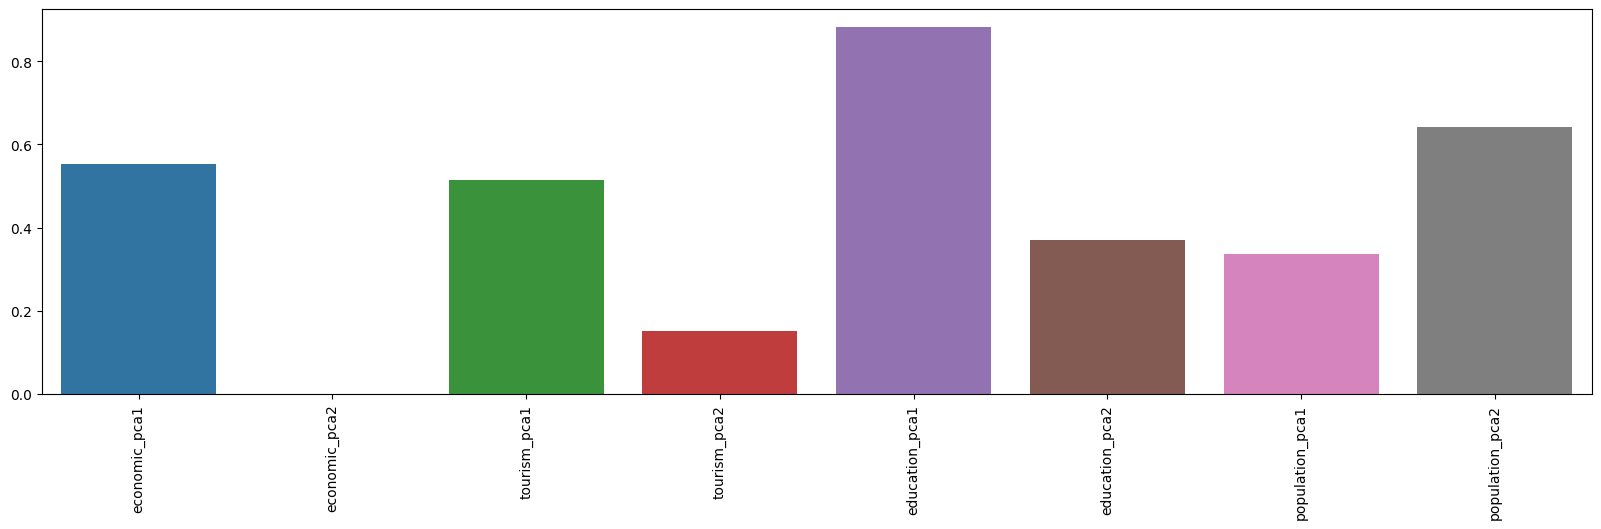

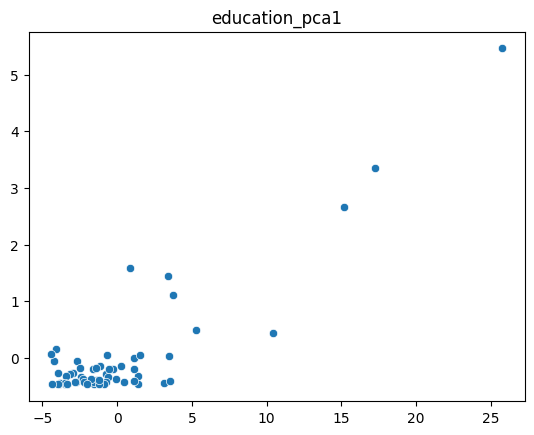

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_coefs = []
for idx in range(len(categories_cols)):
    corr = np.abs(np.corrcoef(data_pca_X[:, idx], data_y)[0, 1])
    if(pd.isnull(corr)):
        corr = 0
    corr_coefs.append(corr)
print('Coefficients: ', corr_coefs)
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.barplot(x = categories_cols, y = corr_coefs, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()
sns.scatterplot(x = data_pca_X[:, np.argmax(corr_coefs)], y = data_y)
plt.title(categories_cols[np.argmax(corr_coefs)])
plt.show()

In [42]:
all_idx = np.arange(data_pca_X.shape[0])
np.random.shuffle(all_idx)
train_test_split_idx = int(data_pca_X.shape[0] * 0.8)
train_idx = all_idx[:train_test_split_idx]
test_idx = all_idx[train_test_split_idx:]

In [43]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(data_pca_X[train_idx, :], data_y[train_idx])

LinearRegression()

Coefficients:  [-4.16688827e-02 -1.38777878e-16 -1.01954283e-02 -5.22944273e-02
  1.69579764e-01 -1.29954881e-01 -6.80175167e-02  1.52054650e-01]


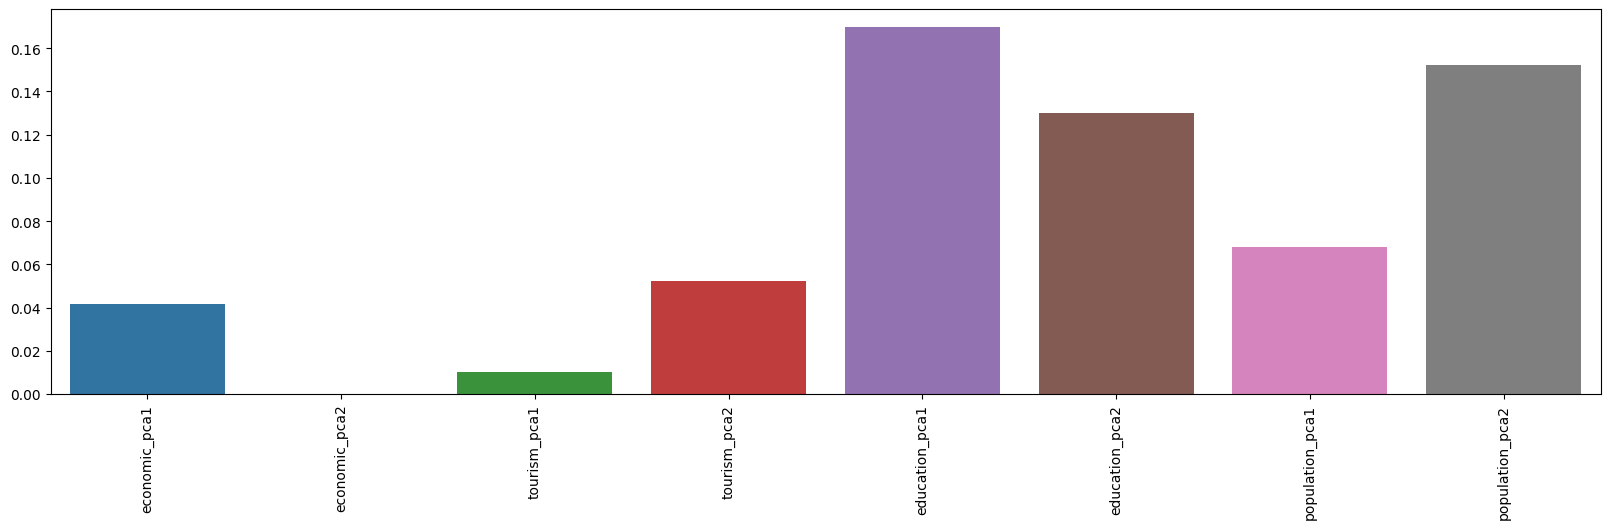

In [44]:
model_coefs = model.coef_
print('Coefficients: ', model_coefs)
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
sns.barplot(x = categories_cols, y = np.abs(model_coefs), ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

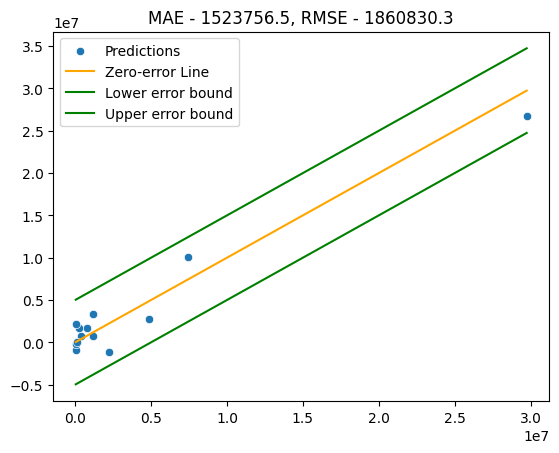

In [45]:
from sklearn import metrics
target_mean = cols_standardization_vals[target_feature[0]]['mean']
target_std = cols_standardization_vals[target_feature[0]]['std']
true = data_y[test_idx] * target_std + target_mean
pred = model.predict(data_pca_X[test_idx, :]) * target_std + target_mean
mae = metrics.mean_absolute_error(true, pred)
rmse = np.sqrt(metrics.mean_squared_error(true, pred))
sns.scatterplot(x = true, y = pred, label = 'Predictions')
sns.lineplot(x = true, y = true, label = 'Zero-error Line', color = 'orange')
sns.lineplot(x = true, y = true - 5e6, label = 'Lower error bound', color = 'green')
sns.lineplot(x = true, y = true + 5e6, label = 'Upper error bound', color = 'green')
plt.legend(loc = 'best')
plt.title(f"MAE - {mae:.1f}, RMSE - {rmse:.1f}")
plt.show()

In [46]:
categories_cols

['economic_pca1',
 'economic_pca2',
 'tourism_pca1',
 'tourism_pca2',
 'education_pca1',
 'education_pca2',
 'population_pca1',
 'population_pca2']

In [47]:
model = linear_model.LinearRegression()
model.fit(data_pca_X, data_y)
model_coefs = OrderedDict(zip(['intercept'] + categories_cols, [model.intercept_] + [*model.coef_]))

In [48]:
import json
with open(f'./PreProcessed_Datasets/Models/CitySelectionModel_coefs.json', 'w') as save_file:
    json.dump(model_coefs, save_file)